# Optional readings: Dummy Encoding and Data Transformations

The following material is largely borrowed from

<table style="width: 100%;">
    <tr style="background-color: transparent;"><td>
        <img src="https://d8a-88.github.io/fa19/assets/images/blue_text.png" width="250px" style="margin-left: 0;" />
    </td><td>
        <p style="text-align: right; font-size: 10pt;"><strong>Economic Models</strong>, Fall 2020<br>
            Dr. Eric Van Dusen<br>
            Notebook by Chris Pyles</p></td></tr>
</table>

This module focuses on the application of the data science techniques from lecture. 
You will practice single variable ordinary least squares regression and go through a guided introduction to 
multivariable OLS using the package `statsmodels`, then create your own multivariable OLS model.

After this lab, you should be able to

1. Use the `statsmodels` package to create single variable and multivariable OLS models
2. Understand how to quantitatively evaluate models using the root-mean-squared error
3. Look for and use relationships between variables to select features for regression

In [ ]:
from datascience import *
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
plt.style.use('seaborn-muted')
%matplotlib inline
plt.rcParams["figure.figsize"] = [10,7]

In this lab, we will be working with data on credit card defaults and billing. The data covers April to September 2005, with one row for each cardholder. It has the following columns:

| Column | Description |
|-----|-----|
| `credit` | Total amount of credit |
| `sex` | Cardholder sex |
| `education` | Cardholder education level |
| `martial_status` | Cardholder marital status |
| `age` | Cardholder age |
| `bill_{month}05` | Bill amount for specific month |
| `paid_{month}05` | Amount paid in specified month |
| `default` | Whether the cardholder defaulted |

In the cell below, we load the dataset.

In [ ]:
defaults = Table.read_table("defaults.csv")
defaults

credit,sex,education,marital_status,age,bill_sep05,bill_aug05,bill_jul05,bill_jun05,bill_may05,bill_apr05,paid_sep05,paid_aug05,paid_jul05,paid_jun05,paid_may05,paid_apr05,default
20000,female,undergraduate,married,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1
120000,female,undergraduate,single,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
90000,female,undergraduate,single,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
50000,female,undergraduate,married,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
50000,male,undergraduate,married,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
50000,male,gradaute,single,37,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0
500000,male,gradaute,single,29,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
100000,female,undergraduate,single,23,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0
140000,female,diploma,married,28,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0
20000,male,diploma,single,35,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0


## Question 0: Dummy Variables

### Motivation

Dummy variables are used to encode categorical data. There are 2 cases when this may occur:

* A variable has non-numeric values, e.g. having `M` or `F` for  `sex`, `HS` or `college` or `Masters` for `education`, and so on.
* A variable has categorical numeric values, e.g. the star ratings of a business on Yelp. 

In the first case, the reason is obvious: we need a way to model a qualitative variable in our model, which is inherently quantitative.

In the second, the reason is more subtle. Even though the data may be quantitative, we would instead like to think of them as belonging in groups or bins; for Yelp stars, there are 3 star restaurants, 3.5 star restaurants, and so on. Typically, the data are not continuous, and doing arithmetic operations such as finding the difference between 2 observations would not too meaningful.

**Question 0.1:** Which of the columns in `defaults_raw` would we need dummies for in order to use in an OLS model? Assign `q0_1` to an array of these column _labels_.

```
BEGIN QUESTION
name: q0_1
```

In [ ]:
q0_1 = make_array("sex", "education", "marital_status", "age") # last is optional # SOLUTION
q0_1

array(['sex', 'education', 'marital_status', 'age'], dtype='<U14')

In [ ]:
## Test ##
assert len(q0_1) in [3, 4]
assert "sex" in q0_1
assert "education" in q0_1
assert "marital_status" in q0_1
assert len(q0_1) == 3 or "age" in q0_1

### How Dummy Variables Work

A dummy variable encoding turns the original column of data into many columns, with each new column representing a unique value of the original column. For each observation's value that we seek to encode, the value's corresponding column will be marked with a 1, while all other columns will be marked with a 0. 

For example, if we had a column for sex where `male` and `female` were the only unique values, it would be turned into 2 columns: `male` and `female`. An observation that is male will have the `male` column be 1 and the `female` column be 0.

### Creating Dummy Variables

Let's start by creating dummy variables for the `sex` column of `defaults`. To create dummy variables, we need to know all of the **unique** values of our variable, since we will need to create one new column for each of these. The function `np.unique` will give you an array of the unique values of the array passed to it.

**Question 0.2:** Assign `unique_vals` to an array of the unique values in the `sex` column of `defaults`.

```
BEGIN QUESTION
name: q0_2
```

In [ ]:
unique_vals = np.unique(defaults.column("sex")) # SOLUTION
unique_vals

array(['female', 'male'], dtype='<U6')

In [ ]:
## Test ## 
assert len(unique_vals) == 2
assert "male" in unique_vals
assert "female" in unique_vals

Now that we know these values, we want to create a column for each value with a 1 if the value for that row equals the column value, and a 0 otherwise. To do this, we'll begin by creating dummy encodings with `True` and `False` values, instead of 1's and 0's. 

**Question 0.3:** For each value in `unique_vals`, add a column to `defaults` with `True` or `False` values, instead of 1's and 0's. For example, if an individual was male, then `sex_male` will be `True` and `sex_female` will be `False`.

*Hint*: you can check whether an array is equal to a certain value with `==`. 

```
BEGIN QUESTION
name: q0_3
```

In [ ]:
# BEGIN SOLUTION NO PROMPT
for val in unique_vals:
    dummy_vals = defaults.column('sex') == val
    defaults = defaults.with_column("sex_" + val, dummy_vals)
# END SOLUTION
""" # BEGIN PROMPT
for val in unique_vals:
    dummy_vals = ...
    defaults = defaults.with_column("sex_" + val, ...)
""" # END PROMPT

defaults

credit,sex,education,marital_status,age,bill_sep05,bill_aug05,bill_jul05,bill_jun05,bill_may05,bill_apr05,paid_sep05,paid_aug05,paid_jul05,paid_jun05,paid_may05,paid_apr05,default,sex_female,sex_male
20000,female,undergraduate,married,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1,True,False
120000,female,undergraduate,single,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,True,False
90000,female,undergraduate,single,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,True,False
50000,female,undergraduate,married,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,True,False
50000,male,undergraduate,married,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,False,True
50000,male,gradaute,single,37,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0,False,True
500000,male,gradaute,single,29,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0,False,True
100000,female,undergraduate,single,23,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0,True,False
140000,female,diploma,married,28,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0,True,False
20000,male,diploma,single,35,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0,False,True


In [ ]:
## Test ##
assert defaults.num_columns == 20
assert "sex_male" in defaults.labels
assert "sex_female" in defaults.labels
assert defaults.column("sex_male").dtype == bool
assert defaults.column("sex_female").dtype == bool

Notice that we've created columns with names of the format `sex_{value}`. However, we still have a problem: these columns have boolean values, not integers!

**Question 0.4:** Cast our boolean values in `sex_male` and `sex_female` to integers using `Table.apply`. Recall that we can **typecast** a boolean to an integer by calling the `int` function on it. This will map `True` to 1 and `False` to 0.

```
BEGIN QUESTION
name: q0_4
```

In [ ]:
# BEGIN SOLUTION NO PROMPT
for val in unique_vals:
    int_vals = defaults.apply(int, "sex_" + val)
    defaults = defaults.with_column("sex_" + val, int_vals)
# END SOLUTION
""" # BEGIN PROMPT
for val in unique_vals:
    int_vals = defaults.apply(..., ...)
    flips = defaults.with_column("sex_" + val, ...)
""" # END PROMPT
    
defaults

credit,sex,education,marital_status,age,bill_sep05,bill_aug05,bill_jul05,bill_jun05,bill_may05,bill_apr05,paid_sep05,paid_aug05,paid_jul05,paid_jun05,paid_may05,paid_apr05,default,sex_female,sex_male
20000,female,undergraduate,married,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,0
120000,female,undergraduate,single,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,1,0
90000,female,undergraduate,single,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,1,0
50000,female,undergraduate,married,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,1,0
50000,male,undergraduate,married,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,0,1
50000,male,gradaute,single,37,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0,0,1
500000,male,gradaute,single,29,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0,0,1
100000,female,undergraduate,single,23,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0,1,0
140000,female,diploma,married,28,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0,1,0
20000,male,diploma,single,35,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0,0,1


In [ ]:
## Test ##
assert defaults.column("sex_male").dtype in [np.int64, int]
assert defaults.column("sex_female").dtype in [np.int64, int]

Congratulations, you've now created dummy variables for a categorical variable! Notice that our choice to iterate through the unique values means that we can use this same logic for any arbitrarily large number of unique values. The function `get_dummies` defined below encapsulates this logic that we've built, albeit with a simplified encoding step. Note that this function also drops the first of the unique values by default via the `drop_first` argument. This function will be provided for you in the future.

In [ ]:
def get_dummies(tbl, col, drop=True, drop_first=True):
    """Creates dummy variables for a column of a table"""
    values = np.unique(tbl.column(col))
    for val in values:
        tbl = tbl.drop(col + "_" + str(val))
        if drop_first and val == values[0]:
            continue
        encoding = tbl.apply(lambda s: int(s == val), col)
        tbl = tbl.with_column(col + "_" + str(val), encoding)
    if drop:
        tbl = tbl.drop(col)
    return tbl

By default, `get_dummies` will drop the original column and one of the dummy columns. In our example, `sex` and `sex_female` will be dropped, but that's ok: we can still figure out whether a person is male or female by looking at `sex_male` alone. If `sex_male` is 1, then the person is male; if `sex_male`, is 0, then the person is female. This same logic can be applied to columns with more than two unique values.

**Question 0.5:** Use the `get_dummies` function to get dummies for the variables you listed in Question 0.1. Leave `drop` and `drop_first` set to their default values. Make sure you re-encode the `sex` column so that it drops `sex_female` for us.

```
BEGIN QUESTION
name: q0_5
```

In [ ]:
defaults = get_dummies(defaults, "sex")                 # SOLUTION
defaults = get_dummies(defaults, "education")           # SOLUTION
defaults = get_dummies(defaults, "marital_status")      # SOLUTION
defaults

credit,age,bill_sep05,bill_aug05,bill_jul05,bill_jun05,bill_may05,bill_apr05,paid_sep05,paid_aug05,paid_jul05,paid_jun05,paid_may05,paid_apr05,default,sex_male,education_gradaute,education_other,education_undergraduate,marital_status_other,marital_status_single
20000,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0,0,0,1,0,0
120000,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0,0,0,1,0,1
90000,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,0,0,1,0,1
50000,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0,0,0,1,0,0
50000,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1,0,0,1,0,0
50000,37,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0,1,1,0,0,0,1
500000,29,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0,1,1,0,0,0,1
100000,23,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0,0,0,0,1,0,1
140000,28,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0,0,0,0,0,0,0
20000,35,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0,1,0,0,0,0,1


In [ ]:
## Test ##
for col in ["sex", "education", "marital_status"]:
    assert col not in defaults.labels
assert "sex_male" in defaults.labels
assert "sex_female" not in defaults.labels

## Part 1: Single Variable OLS

Now that we have created some dummy variables, let's start doing regression. In this section, we'll perform single variable regression using the `statsmodels` package.

**Question 1.1:** Use `statsmodels` to regress `bill_sep05` on `credit`. Store the predicted values in `y_hat`.

_Hint:_ Don't forget to add a constant to `x` using `sm.add_constant` inside your `sm.OLS` call.

```
BEGIN QUESTION
name: q1_1
```

In [ ]:
x = defaults.column("credit")
y = defaults.column("bill_sep05")

model = sm.OLS(y, sm.add_constant(x))
results = model.fit()
y_hat = results.fittedvalues

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     2661.
Date:                Tue, 11 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:04:48   Log-Likelihood:            -3.7750e+05
No. Observations:               30000   AIC:                         7.550e+05
Df Residuals:                   29998   BIC:                         7.550e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.409e+04    665.335     36.211      0.000    2.28e+04    2.54e+04
x1             0.1620      0.003     51.582      0.000       0.156       0.168
==============================================================================
Omnibus:                    12862.175   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            75697.302
Skew:                           1.991   Prob(JB):                         0.00
Kurtosis:                       9.686   Cond. No.                     3.46e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.46e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
## Test ##
assert model.data.xnames == ["const", "x1"]
assert model.data.exog.shape == (30000, 2)
assert (model.endog == defaults.column("bill_sep05")).all()
assert len(results.fittedvalues) == 30000
assert len(y_hat) == 30000

In [ ]:
## Hidden Test ##
assert (model.data.exog[:,1] == defaults.column("credit")).all()
assert (results.fittedvalues == y_hat).all()
assert np.allclose(results.params, np.array([2.40924809e+04, 1.61990386e-01]))

Now that we have some predictions, let's plot the original data and the regression line.

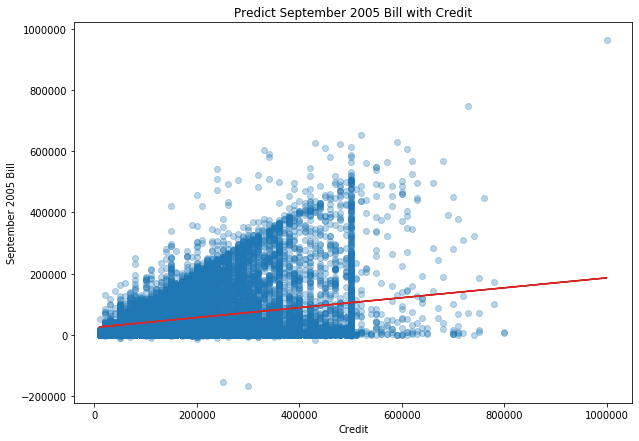

In [ ]:
plt.scatter(x, y, color="tab:blue", alpha=0.3)
plt.plot(x, y_hat, color="tab:red")
plt.title("Predicting September 2005 Bill with Credit")
plt.xlabel("Credit")
plt.ylabel("September 2005 Bill");

We can see that the fit line above doesn't really conform to the data very well. In order to help determine whether there is a relationship between credit and the September 2005 bill, let's estimate how confident we are in the significance of our $\hat{\beta}$ coefficient.

**Question 1.2:** Fill in the code below to bootstrap our $\hat{\beta}$ and find the 95% confidence interval. Store the lower and upper bounds as `ci95_lower` and `ci95_upper`, respectively. (The cell may take a couple minutes to run.)

_Hint:_ We can get the slope of our regression line from the results with `results.params.item(1)`.

```
BEGIN QUESTION
name: q1_2
```

In [ ]:
np.random.seed(42) # SEED
betas = make_array()

for i in np.arange(200):
    sample = defaults.sample(5000)    # defaults is a huge table, so we'll only sample 5000 rows
    sample_x = sample.column("credit")                       # SOLUTION
    sample_y = sample.column("bill_sep05")                   # SOLUTION
    beta_model = sm.OLS(sample_y, sm.add_constant(sample_x)) # SOLUTION
    beta_results = beta_model.fit()                          # SOLUTION
    slope = beta_results.params.item(1)                      # SOLUTION
    betas = np.append(betas, slope)                          # SOLUTION

ci95_lower = percentile(2.5, betas)                          # SOLUTION
ci95_upper = percentile(97.5, betas)                         # SOLUTION

print("95% CI: ({}, {})".format(ci95_lower, ci95_upper))

95% CI: (0.13769201355328184, 0.18482873448177967)


In [ ]:
## Test ##
0.13 <= ci95_lower <= 0.17

True

In [ ]:
## Test ##
0.16 <= ci95_upper <= 0.20

True

In [ ]:
## Hidden Test ##
np.isclose(ci95_lower, 0.13769201355328192)

True

In [ ]:
## Hidden Test ##
np.isclose(ci95_upper, 0.18482873448177958)

True

**Question 1.3:** Using your 95% confidence interval, is it likely that the credit has an effect on the September 2005 bill? Assign `q1_3` to the letter corresponding to your answer.

<ol type="A" style="list-style-type: lower-alpha;">
    <li>Credit <em>does</em> have an effect on the bill</li>
    <li>Credit does <em>not</em> have an effect on the bill</li>
</ol>

```
BEGIN QUESTION
name: q1_3
```

In [ ]:
q1_3 = "a" # SOLUTION

In [ ]:
## Test ##
assert q1_3 in ["a", "b"]

In [ ]:
## Hidden Test ##
assert q1_3 == "a"

Obviously, we can see that our best-fit line does not predict perfectly. There are plenty of points in the scatterplot that do not fall on the line. But how do we quantify the error of our model? There are many so-called *loss functions*, but in this notebook we will use the **root-mean-squared error**, which is defined as

$$\Large
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left ( y_i - \hat{y}_i \right ) ^2 }
$$

where $n$ is the number of observations. The effect of this is to take the mean of the distance of each value of $\hat{y}$ from its corresponding value in $y$; squaring these values keeps them positive, and then we take the square root to correct the units of the error.

**Question 1.4:** Complete the function `rmse` below which computes the root-mean-squared error of the prediction `y_hat` on `y`. Then assign the RMSE of our predictions in `y_hat` to `single_var_error`. **Don't use a `for` loop.**

```
BEGIN QUESTION
name: q1_4
```

In [ ]:
def rmse(y, y_hat):
    return np.sqrt(np.mean((y - y_hat)**2)) # SOLUTION

single_var_error = rmse(y, y_hat) # SOLUTION
single_var_error

70571.40305975602

In [ ]:
## Test ##
np.random.seed(1234)
y2 = np.random.uniform(0, 10, 5)
y_hat2 = np.random.uniform(0, 10, 5)
np.isclose(rmse(y2, y_hat2), 2.440102731334708)

True

In [ ]:
## Test ##
70000 <= single_var_error <= 80000

True

In [ ]:
## Hidden Test ##
np.random.seed(2345)
y2 = np.random.uniform(0, 10, 5)
y_hat2 = np.random.uniform(0, 10, 5)
np.isclose(rmse(y2, y_hat2), 4.034226624125118)

True

In [ ]:
## Hidden Test ##
np.isclose(single_var_error, 70571.40305975602)

True

In looking through different features, you should have noticed that most of them don't follow a linear relationship very well. In practice, you often need _multiple_ features (explanatory variables) to predict an outcome variable, and it is for this reason that we often use **multiple linear regression** to predict variables.

## Part 2: Guided Multivariable OLS

When we predict a variable $y$ based on some set of $p$ explanatory variables $x$, we create a set of weights $\alpha$ and $\beta_i$ such that we have

$$\Large
y = \alpha + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p + \varepsilon
$$

Because of the error term $\varepsilon$, we will instead create predictions $\hat{y}$, such that 

$$\Large
\hat{y} = \alpha + \hat{\beta}_1 x_1 + \hat{\beta}_2 x_2 + \cdots + \hat{\beta}_p x_p
$$

Let's model the September bill based on the other bills in the data set (April to August). Recall from lecture that we can model an outcome variable `Y` based on columns from our data `defaults` by extracting the values of the table into an array. In the cell below, we create the arrays `X` and `Y`.

In [ ]:
X = defaults.select("bill_aug05", "bill_jul05", "bill_jun05", "bill_may05", "bill_apr05", "default").values
Y = defaults.column("bill_sep05")

Recall that we can fit a multivariable OLS model using `statsmodels` by calling the function `sm.OLS` on the outcome and explanatory variables. In the cell below, we create a model based on _all_ the columns in the table (except, of course, the outcome variable).

In [ ]:
# create an OLS object with the data
model = sm.OLS(Y, sm.add_constant(X))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                 4.827e+04
Date:                Fri, 31 Jul 2020   Prob (F-statistic):               0.00
Time:                        15:29:08   Log-Likelihood:            -3.4328e+05
No. Observations:               30000   AIC:                         6.866e+05
Df Residuals:                   29993   BIC:                         6.866e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2770.1379    174.427     15.881      0.000    2428.254    3112.022
x1             0.9109      0.005    178.720      0.000       0.901       0.921
x2             0.0417      0.006      6.775      0.000       0.030       0.054
x3             0.0227      0.007      3.080      0.002       0.008       0.037
x4             0.0156      0.008      1.842      0.066      -0.001       0.032
x5             0.0085      0.007      1.243      0.214      -0.005       0.022
x6         -1112.3004    313.866     -3.544      0.000   -1727.492    -497.109
==============================================================================
Omnibus:                    23268.376   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8430757.621
Skew:                           2.670   Prob(JB):                         0.00
Kurtosis:                      84.952   Cond. No.                     4.25e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.25e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Question 2.1:** Which variable corresponds to `bill_jul05`?

<ol style="list-style-type: lower-alpha;">
    <li>$x_1$</li>
    <li>$x_2$</li>
    <li>$x_3$</li>
    <li>$x_4$</li>
    <li>$x_5$</li>
</ol>

Assign your answer to `q2_1` below.

```
BEGIN QUESTION
name: q2_1
```

In [ ]:
q2_1 = "b" # SOLUTION

In [ ]:
## Test ##
q2_1 in ["a", "b", "c", "d", "e"]

True

In [ ]:
## Hidden Test ##
q2_1 == "b"

True

**Question 2.2:** What is the standard error of the coefficient of `bill_jun05`?

<ol style="list-style-type: lower-alpha;">
    <li>0.005</li>
    <li>0.010</li>
    <li>0.039</li>
    <li>0.007</li>
</ol>

Assign your answer to `q2_2` below.

```
BEGIN QUESTION
name: q2_2
```

In [ ]:
q2_2 = "d" # SOLUTION

In [ ]:
## Test ##
q2_2 in ["a", "b", "c", "d"]

True

In [ ]:
## Hidden Test ##
q2_2 == "d"

True

**Question 2.3:** Which bills are likely good predictors of `bill_sep05`? List the letters corresponding to those variables in the array `q2_3`.

<ol style="list-style-type: lower-alpha;">
    <li><code>bill_aug05</code></li>
    <li><code>bill_jul05</code></li>
    <li><code>bill_jun05</code></li>
    <li><code>bill_may05</code></li>
    <li><code>bill_apr05</code></li>
    <li><code>default</code></li>
</ol>

```
BEGIN QUESTION
name: q2_3
```

In [ ]:
q2_3 = make_array("a", "b", "c", "f") # SOLUTION NO PROMPT
""" # BEGIN PROMPT
q2_3 = make_array(...)
"""; # END PROMPT

In [ ]:
## Test ##
all([a in ["a", "b", "c", "d", "e", "f"] for a in q2_3])

True

In [ ]:
## Hidden Test ##
list(sorted(q2_3)) == ["a", "b", "c", "f"]

True

**Question 2.4:** Interpret the value of the coeffiecient of the `default` column in our model. Assign the letter corresponding to the true statement below to `q2_4`.

<ol style="list-style-type: lower-alpha;">
    <li>When <code>default</code> changes from 0 to 1, the Sep bill decreases by \$1112.30.</li>
    <li>When <code>default</code> changes from 1 to 0, the Sep bill decreases by \$1112.30.</li>
    <li>When <code>default</code> changes from 1 to 0, the Sep bill decreases to \$1112.30.</li>
    <li>When <code>default</code> changes from 0 to 1, the Sep bill decreases to \$1112.30.</li>
</ol>

```
BEGIN QUESTION
name: q2_4
```

In [ ]:
q2_4 = "a" # SOLUTION

In [ ]:
## Test ##
q2_4 in ["a", "b", "c", "d"]

True

In [ ]:
## Hidden Test ##
q2_4 == "a"

True

Now let's look and see what values our model predicts for our outcome variable. Recall that we can extract the fitted values from the results using `results.fittedvalues`. 

**Question 2.5:** Assign `Y_hat` to the fitted values of `results`. Then assign `multi_rmse` to the RMSE of this prediction based on `Y`.

```
BEGIN QUESTION
name: q2_5
```

In [ ]:
Y_hat = results.fittedvalues    # SOLUTION
multi_rmse = rmse(Y, Y_hat)    # SOLUTION
multi_rmse

22556.46769554734

In [ ]:
## Test ##
len(Y_hat) == defaults.num_rows

True

In [ ]:
## Test ##
22000 <= multi_rmse <= 23000

True

In [ ]:
## Hidden Test ##
np.random.seed(1234)
expected = np.array([131575.00462172,  26777.22647566,   2573.18036936,   2824.68190761, 50299.39627643])
actual = np.random.choice(Y_hat, 5)
np.allclose(expected, actual)

False

In [ ]:
## Hidden Test ##
np.isclose(multi_rmse, 22561.189743524323)

False

We see from this RMSE that the prediction is (much) better than the single variable case, but it's still not too good. Let's try and select better features to see if we can lower our RMSE.

## Part 3: Unguided Multivariable OLS

In this section of the assignment, you will use `statsmodels` and OLS to create your own model to predict the September 2005 bill. Your model will be scored out of **5 points**, and a portion of your score will be determined based on your RMSE. The scores you will receive are given in the table below.

| RMSE | Score (out of 5) |
|-----|-----|
| $\le$ 20,000 | 6 |
| $\le$ 30,000 | 5 |
| $\le$ 50,000 | 4 |
| $\le \infty$ | 3 |

Note that it is possible to receive a 6 out of 5 for an especially good model, and that as long as you *create a model*, you are guaranteed a 3 out of 5. **To submit your model, you must assign `my_labels` to an array of the columns you want your model to use. You may not use more than 10 columns and, of course, you can't use the column `bill_sep05` in your features.** Your model RMSE will be calculated using the following code:

```python
X, Y = defaults.select(my_labels).values, defaults.column("bill_sep05")
model = sm.OLS(Y, sm.add_constant(X))
results = model.fit()
Y_hat = results.fittedvalues
rmse(Y, Y_hat)
```

Add and remove cells below as needed, but *make sure you define `my_labels`*. We have provided code for you to create your `X` array; just fill in the `...` in `my_labels` with your columns and use the space at the bottom to work on your model. Since the outcome variable hasn't changed, you can reuse the `Y` array from earlier. Good luck!

```
BEGIN QUESTION
name: q3
points: 3
```

In [ ]:
# BEGIN SOLUTION NO PROMPT
my_labels = make_array('bill_aug05','bill_jun05','bill_may05','bill_apr05','paid_sep05',
                       'paid_aug05','paid_jul05','paid_jun05','paid_may05','paid_apr05')

my_X = defaults.select(my_labels).values

my_model = sm.OLS(Y, sm.add_constant(my_X))
my_results = my_model.fit()
my_Y_hat = my_results.fittedvalues
rmse(Y, my_Y_hat)
# END SOLUTION
""" # BEGIN PROMPT
my_labels = make_array(...)

my_X = defaults.select(my_labels).values

my_model = ...
my_results = ...
my_Y_hat = ...
rmse(...)
"""; # END PROMPT

In [ ]:
## Test ##
len(my_labels) <= 10

True

In [ ]:
## Test ##
"bill_sep05" not in my_labels

True

```
BEGIN QUESTION
name: q3_1
```

In [ ]:
## Hidden Test ##
my_X = defaults.select(my_labels).values
my_model = sm.OLS(Y, sm.add_constant(my_X))
my_results = my_model.fit()
my_Y_hat = my_results.fittedvalues
rmse(Y, my_Y_hat) <= 50000

True

```
BEGIN QUESTION
name: q3_2
```

In [ ]:
## Hidden Test ##
my_X = defaults.select(my_labels).values
my_model = sm.OLS(Y, sm.add_constant(my_X))
my_results = my_model.fit()
my_Y_hat = my_results.fittedvalues
rmse(Y, my_Y_hat) <= 30000

True

```
BEGIN QUESTION
name: q3_3
```

In [ ]:
## Hidden Test ##
my_X = defaults.select(my_labels).values
my_model = sm.OLS(Y, sm.add_constant(my_X))
my_results = my_model.fit()
my_Y_hat = my_results.fittedvalues
rmse(Y, my_Y_hat) <= 20000

True

## Part 4: Reflection

In this section of the assignment, you will answer some conceptual questions about the choices you made in creating your model in Part 3. This section heavily influences your grade, as we are looking to ensure that you are using econometric intuition while modeling. Please answer thoughtfully and, as always, *show us the numbers*.

**Question 4:** Choose a column you regressed on in your Question 3 model. Report its coefficient, $t$ statistic, and 95% CI. Interpret the coefficient's value. Is the variable likely significant? Explain.

_Note:_ You will be graded based upon a nuanced explanation that makes use of the econometric intuition you have been taught. Your answer should reflect that intuition and should take 3-4 sentences at a minimum.

```
BEGIN QUESTION
name: q4
manual: true
```

<div class="alert alert-danger">

<strong>SOLUTION:</strong> Full points with reporting all values and explanation using $t$ statistic and/or 95% CI.
    
</div>

## Conclusion

In this lab, you learned how to encode categorical features as dummy variables, how to use statsmodels to perform and analyze single variable regressions, and created your own multivariable model and analyzed its efficacy.

### References

UCI Machine Learning Repository: Default of credit card clients Data Set. (n.d.). Retrieved August 11, 2020, from https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#
